### They are all equally spaced

In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from matplotlib.animation import FuncAnimation

In [26]:
########################################                 Define constants                   #############################################
N = 30
fixed_lam   = 1
k_a = 2 * np.pi / fixed_lam
fixed_gamma = 1

fixed_dist  = 0.235 * fixed_lam
fixed_phi   = np.pi/2

t_max    = 2* np.pi
t_size   = 100
########################################################################################################################    
times  = np.linspace(0, t_max, t_size) * fixed_gamma

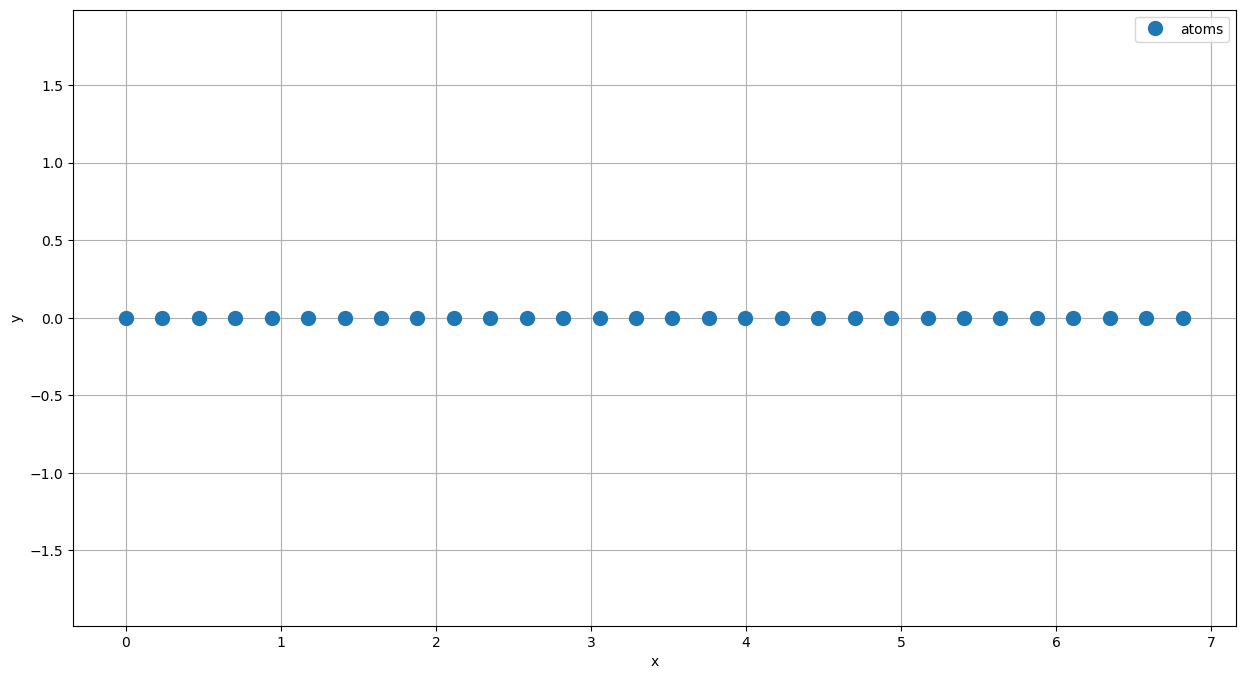

In [33]:
########################################               define the geometry                 #############################################
def phi(t):
    return np.sin(t)**2

def dipole_vector(t):
    """Returns the dipole vector given its orientation by angle phi."""
    dipole = np.array([np.pi/2 + np.cos(phi(t)), np.pi/2 + np.sin(phi(t)), 0])
    return dipole

def chain_positions(distance = fixed_dist, N = N):
    Pos = np.zeros((N, 3))
    for i in range(N):
        Pos[i,0] = i * distance
    return Pos

positions = chain_positions()

# Find the highest x_value
max_x = np.max(positions[:, 0])
scale = 0.1 * max_x
# Plot the atom positions
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(positions[:, 0], positions[:, 1], 'o', markersize=10, label='atoms')
#for i, position in enumerate(positions):
#    ax.arrow(position[0], position[1], d_hats[i][0] * scale, d_hats[i][1] * scale, 
#             head_width=0.2*scale, head_length=0.2*scale, fc='r', ec='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.grid(True)
ax.legend()
ax.axis('equal')
plt.show()

In [34]:
########################################             create the Hamiltonean                 #################################################
def Green_tensor(r_a, r_b, k_a):
    r_ab = r_b - r_a
    abs_r_ab = np.linalg.norm(r_ab)
    kappa = k_a * abs_r_ab
    return (np.exp(1j * kappa) / (4 * np.pi * kappa ** 2 * abs_r_ab)
                    * ((kappa ** 2 + 1j * kappa - 1) * np.eye(3)
                       + (- kappa ** 2 - 3 * 1j * kappa + 3)
                       * np.outer(r_ab, r_ab) / (abs_r_ab ** 2)))

def Gamma_matrix(distance, dipoles):
    positions = chain_positions(distance)
    G_matrix = np.zeros((N, N), dtype=complex)
    for a in range(N):
        for b in range(N):
            G_matrix[a, b] = fixed_gamma
            r_a, r_b = positions[a], positions[b]
            if np.linalg.norm(r_b - r_a) > 1e-5:
                d_a, d_b = dipoles[a], dipoles[b]
                k_a = 2 * np.pi / fixed_lam
                result = (6 * np.pi * fixed_gamma / k_a * np.matmul(np.conj(d_a), np.matmul(Green_tensor(r_a, r_b, k_a), d_b.T)))
                G_matrix[a, b] = np.imag(result)
    return G_matrix

def V_matrix(distance, dipoles):
    positions = chain_positions(distance, N)
    V_matrix = np.zeros((N, N), dtype=complex)
    for a in range(N):
        for b in range(N):
            r_a, r_b = positions[a], positions[b]
            V_matrix[a, b] = 0
            if np.linalg.norm(r_b - r_a) > 1e-5:
                d_a, d_b = dipoles[a], dipoles[b]
                k_a = 2 * np.pi / fixed_lam
                result = (3 * np.pi * fixed_gamma / k_a * np.matmul(np.conj(d_a), np.matmul(Green_tensor(r_a, r_b, k_a), d_b.T)))
                V_matrix[a, b] = np.real(result)
    return V_matrix
    
def H_eff(t = 0, distance = fixed_dist):
    dipoles = [dipole_vector(t) for _ in range(N)]
    G = Gamma_matrix(distance, dipoles)
    V = V_matrix(distance, dipoles)
    return Qobj(V) - 1j / 2 * Qobj(G)

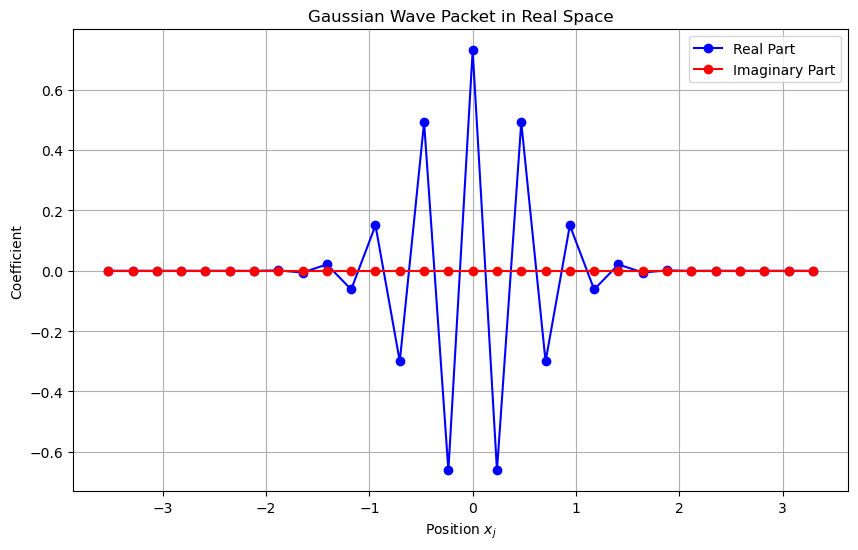

In [35]:
################ TRY to get the Wave-packet
k_s = np.pi / fixed_dist
sigma = 0.1 * k_s
kd_range = np.arange(0, N) * 2 * np.pi / (N * fixed_dist)
center_index = N // 2
x_j = (np.arange(N) - center_index) * fixed_dist

# Calculate the Gaussian wave packet in real space
coefficients = np.sqrt(sigma / np.sqrt(2 * np.pi)) * np.exp(-1j * k_s * x_j) * np.exp(-sigma**2 * x_j**2)
wave_packet = sum(coeff * basis(N, j) for j, coeff in enumerate(coefficients))
psi0 = wave_packet.unit()
# Plot the real and imaginary parts of the wave packet coefficients
plt.figure(figsize=(10, 6))
plt.plot(x_j, coefficients.real, 'bo-', label='Real Part')
plt.plot(x_j, coefficients.imag, 'ro-', label='Imaginary Part')
plt.xlabel('Position $x_j$')
plt.ylabel('Coefficient')
plt.title('Gaussian Wave Packet in Real Space')
plt.legend()
plt.grid(True)
plt.show()
#psi0=basis(N, 0)
psi0 = psi0.tidyup()

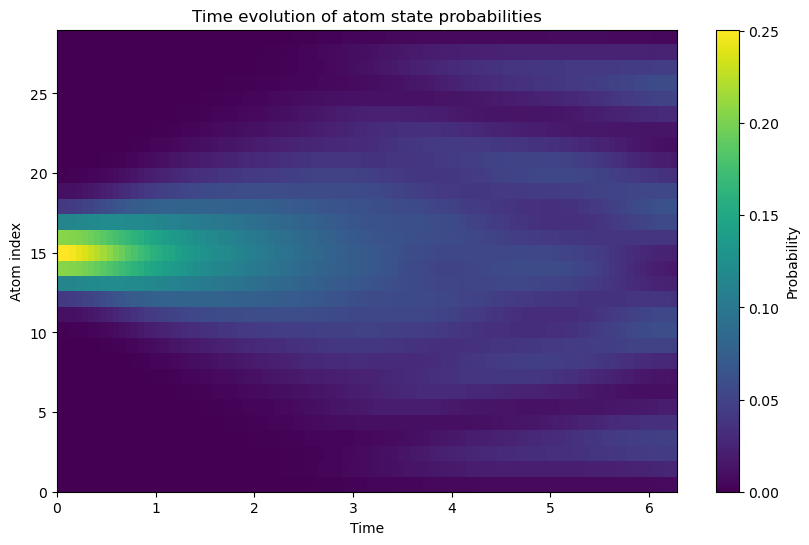

In [36]:
# Solve the time evolution
result = mesolve(H_eff, psi0, times, [], [], args={'distance': fixed_dist})

# Extract and plot the results
populations = [expect(basis(N, i).proj(), result.states) for i in range(N)]

# Plot the time evolution of atom state probabilities as a heatmap
plt.figure(figsize=(10, 6))
plt.imshow(populations, aspect='auto', origin='lower', cmap='viridis', extent=[0, times[-1], 0, N-1])
plt.colorbar(label='Probability')
plt.xlabel('Time')
plt.ylabel('Atom index')
plt.title('Time evolution of atom state probabilities')
plt.show()